In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

In [5]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
!nvidia-smi

Wed Jun  9 05:44:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = "/content/drive/My Drive/TestImages/dataset"
CATEGORIES = ["with_mask", "without_mask","improper_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

[INFO] loading images...


In [6]:
from tqdm import tqdm
dataRaw = []
labels = []

for category in (CATEGORIES):
    path = os.path.join(DIRECTORY, category)
    for img in tqdm(os.listdir(path)):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	#image = preprocess_input(image)

    	dataRaw.append(image)
    	labels.append(category)

  3%|▎         | 50/1903 [00:00<00:13, 141.94it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 867/867 [00:14<00:00, 58.48it/s]


In [7]:
data = []
for img in dataRaw:
  data.append(preprocess_input(img))

In [8]:
lb = LabelBinarizer()
lb.fit(CATEGORIES)
labels1 = lb.transform(labels)
#labels2 = to_categorical(labels1)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels1,
	test_size=0.20, stratify=labels1, random_state=42)

In [9]:
g=2000
print(labels1[g])
print(labels[g])
print(len(labels))

[0 0 1]
without_mask
4688


In [10]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [12]:
baseModel = InceptionResNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
#baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
#headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
  layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

model.summary()

[INFO] compiling model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 111, 111, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 111, 111, 32) 0           batch_normalization_203[0][0]    
____________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")



batch_normalization_340 (BatchN (None, 12, 12, 128)  384         conv2d_340[0][0]                 
__________________________________________________________________________________________________
activation_340 (Activation)     (None, 12, 12, 128)  0           batch_normalization_340[0][0]    
__________________________________________________________________________________________________
conv2d_341 (Conv2D)             (None, 12, 12, 160)  143360      activation_340[0][0]             
__________________________________________________________________________________________________
batch_normalization_341 (BatchN (None, 12, 12, 160)  480         conv2d_341[0][0]                 
__________________________________________________________________________________________________
activation_341 (Activation)     (None, 12, 12, 160)  0           batch_normalization_341[0][0]    
__________________________________________________________________________________________________
conv2d_33

In [13]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
117/117 [==============================] - 92s 448ms/step - loss: 0.2619 - accuracy: 0.8647 - val_loss: 0.1000 - val_accuracy: 0.9670
Epoch 2/20
117/117 [==============================] - 52s 443ms/step - loss: 0.0999 - accuracy: 0.9615 - val_loss: 0.0614 - val_accuracy: 0.9851
Epoch 3/20
117/117 [==============================] - 47s 398ms/step - loss: 0.0790 - accuracy: 0.9696 - val_loss: 0.0485 - val_accuracy: 0.9861
Epoch 4/20
117/117 [==============================] - 46s 396ms/step - loss: 0.0628 - accuracy: 0.9763 - val_loss: 0.0381 - val_accuracy: 0.9872
Epoch 5/20
117/117 [==============================] - 46s 394ms/step - loss: 0.0515 - accuracy: 0.9806 - val_loss: 0.0356 - val_accuracy: 0.9883
Epoch 6/20
117/117 [==============================] - 47s 399ms/step - loss: 0.0509 - accuracy: 0.9801 - val_loss: 0.0309 - val_accuracy: 0.9915
Epoch 7/20
117/117 [==============================] - 52s 442ms/step - loss: 0.0432 - accuracy: 0.9839 - v

In [14]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
               precision    recall  f1-score   support

improper_mask       0.98      1.00      0.99       173
    with_mask       1.00      0.99      0.99       381
 without_mask       0.99      1.00      1.00       384

     accuracy                           0.99       938
    macro avg       0.99      1.00      0.99       938
 weighted avg       0.99      0.99      0.99       938



In [15]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("/content/drive/MyDrive/TestImages/mask_detector_Inception_ResnetV2_20.model", save_format="h5")

[INFO] saving mask detector model...


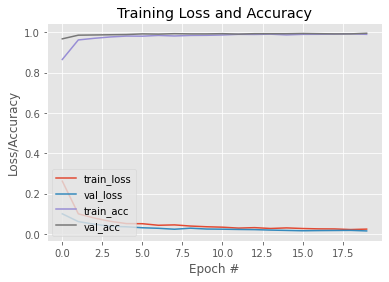

In [16]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")